In [1]:
##############################
### Place all imports here ###
##############################
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from elpv_reader import load_dataset_cv2
import sklearn.metrics as metrics

# Method 1:

# Method 2:

In this method, we create a CNN model with 3 convolutional layers and 2 fully connected layers. The first convolutional layer has 16 filters, the second has 32 filters and the third has 64 filters. The first fully connected layer has 256 neurons and the second has 4 neurons and inbetween these two fully connected layers, there is a dropout which randomly drops some neurons inorder to counteract overfitting. The activation function used in all the layers is ReLU. The model is trained for 20 epochs with a batch size of 64 for training and 32 for validation and testing.

### Load\Preprocess Data
In this stage, we load the data from the reader file and preprocess it. The preprocessing steps include using Stratified Sampling to split the data into training, validation and testing sets. New data is also created for the training set by flipping the images. The training set is used to train the model, the validation set is used to tune the hyperparameters and the testing set is used to test the model. The data is also normalized by dividing it by 255.0 so that the values are between 0 and 1. The data is also shuffled and batched so that the model does not learn the order of the data.

In [2]:
# Load dataset from a new custom function which uses cv2 rather than numpy to load images
# This retains the color channels of the images in the array
images, proba, types = load_dataset_cv2()

In [3]:
# Seperate into training, validation, and testing sets
# Use Stratified Sampling to ensure that the training, validation, and testing sets have the same distribution of classes
# New images can be created by flipping the existing images horizontally and vertically
# This preserves the details necessary for the model to make accurate predictions while also increasing the size of the dataset

unique_proba = np.unique(proba)

# Create a list of the images and labels for each class
sampled_training_data = []
sampled_training_labels = []

sampled_validation_data = []
sampled_validation_labels = []

sampled_testing_data = []
sampled_testing_labels = []

# Sample the data using stratified sampling and append to the lists
for label in unique_proba:
    indices = np.where(proba == label)[0]
    
    sample_training_size = int((len(images) * 0.50) * len(indices) / len(images))
    sample_val_test_size = int((len(images) * 0.25) * len(indices) / len(images))
    
    sample_training_indices = np.random.choice(indices, size=sample_training_size, replace = False)
    sample_validation_indices = np.random.choice(indices, size=sample_val_test_size, replace = False)
    sample_testing_indices = np.random.choice(indices, size=sample_val_test_size, replace = False)
    
    sampled_training_data.append(images[sample_training_indices])
    sampled_training_labels.append(proba[sample_training_indices])
    
    sampled_validation_data.append(images[sample_validation_indices])
    sampled_validation_labels.append(proba[sample_validation_indices])
    
    sampled_testing_data.append(images[sample_testing_indices])
    sampled_testing_labels.append(proba[sample_testing_indices])

In [4]:
# Create training set
# Training set is 50% of the dataset
# Validation and testing sets are 25% of the dataset each
# The following code is used to combine the sampled data into the training, validation, and testing sets
# The data is combined into a single array for each set

# Create new arrays for the training set
training_size = int((len(images) * 0.5) + (len(sampled_training_data[1])) + (len(sampled_training_data[2])))
training_images = np.zeros(shape=(training_size, 300, 300, 3), dtype=np.uint8)
training_labels = np.zeros(shape=(training_size,))

# Fill these new arrays with the sampled data
# Create additional data by flipping the images vertically
index = 0
for i in range(len(sampled_training_data)):
    for j in range(len(sampled_training_data[i])):
        if i == 0 or i == 3:
            temp = sampled_training_data[i][j]
            training_images[index] = temp

            temp = sampled_training_labels[i][j]
            training_labels[index] = temp
            index += 1
        elif i == 1:
            temp = sampled_training_data[i][j]
            training_images[index] = temp

            temp = sampled_training_labels[i][j]
            training_labels[index] = temp
            index += 1
            
            temp = np.flip(sampled_training_data[i][j], 0)
            training_images[index] = temp
            
            temp = sampled_training_labels[i][j]
            training_labels[index] = temp
            index += 1
        elif i == 2:
            temp = sampled_training_data[i][j]
            training_images[index] = temp

            temp = sampled_training_labels[i][j]
            training_labels[index] = temp
            index += 1
            
            temp = np.flip(sampled_training_data[i][j], 0)
            training_images[index] = temp
            
            temp = sampled_training_labels[i][j]
            training_labels[index] = temp
            index += 1

# Create new arrays for the validation and testing sets
val_test_size = int((len(images) * 0.25))
validation_images = np.zeros(shape=(val_test_size - 1, 300, 300, 3), dtype=np.uint8)
validation_labels = np.zeros(shape=(val_test_size - 1,))
testing_images = np.zeros(shape=(int((len(images) * 0.25)) - 1, 300, 300, 3), dtype=np.uint8)
testing_labels = np.zeros(shape=(int((len(images) * 0.25)) - 1,))

# Fill these new arrays with the sampled data
index = 0
for i in range(len(sampled_validation_data)):
    for j in range(len(sampled_validation_data[i])):
        temp = sampled_validation_data[i][j]
        validation_images[index] = temp
        temp = sampled_validation_labels[i][j]
        validation_labels[index] = temp
        
        temp = sampled_testing_data[i][j]
        testing_images[index] = temp
        temp = sampled_testing_labels[i][j]
        testing_labels[index] = temp
        
        index += 1

In [5]:
# Normalize the images to be between 0 and 1
training_images, validation_images, testing_images = training_images / 255.0, validation_images / 255.0, testing_images / 255.0

In [6]:
# Create the datasets
# Shuffle and batch the datasets to ensure that the model does not learn the order of the images
training_dataset = tf.data.Dataset.from_tensor_slices((training_images, training_labels))
training_dataset = training_dataset.shuffle(len(training_images))
training_dataset = training_dataset.batch(64)

validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
validation_dataset = validation_dataset.shuffle(len(validation_images))
validation_dataset = validation_dataset.batch(32)

testing_dataset = tf.data.Dataset.from_tensor_slices((testing_images, testing_labels))
testing_dataset = testing_dataset.shuffle(len(testing_images))
testing_dataset = testing_dataset.batch(32)

### Build the Model
In this stage, we build the model using the Sequential API. The model consists of 3 convolutional layers and 2 fully connected layers. The first convolutional layer has 16 filters, the second has 32 filters and the third has 64 filters. The first fully connected layer has 256 neurons and the second has 4 neurons and inbetween these two fully connected layers, there is a dropout which randomly drops some neurons inorder to counteract overfitting. The activation function used in all the layers is ReLU. The model is trained for 25 epochs with a batch size of 64 for training and 32 for validation and testing. Additionally, there is a callback which stops the training if the validation accuracy does not improve for 5 epochs.

In [7]:
# Create the model
# It is a 3 layer convolutional neural network
model = Sequential()
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(300, 300, 3))) 
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

# Flatten the output of the convolutional layers and add a dense layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))

# Compile the model
# Use the Adam optimizer and Sparse Categorical Crossentropy loss function
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(training_dataset, epochs=25, 
                    validation_data=(validation_dataset),
                    callbacks=[earlystopping_callback])

Epoch 1/25
24/24 [==============================] - 20s 787ms/step - loss: 1.2424 - accuracy: 0.4530 - val_loss: 0.7808 - val_accuracy: 0.3389
Epoch 2/25
24/24 [==============================] - 17s 715ms/step - loss: 0.5560 - accuracy: 0.5007 - val_loss: 0.5500 - val_accuracy: 0.5924
Epoch 3/25
24/24 [==============================] - 17s 717ms/step - loss: 0.4953 - accuracy: 0.5198 - val_loss: 0.4932 - val_accuracy: 0.6519
Epoch 4/25
24/24 [==============================] - 17s 727ms/step - loss: 0.4672 - accuracy: 0.5403 - val_loss: 0.4633 - val_accuracy: 0.6611
Epoch 5/25
24/24 [==============================] - 17s 713ms/step - loss: 0.4687 - accuracy: 0.5403 - val_loss: 0.4788 - val_accuracy: 0.6214
Epoch 6/25
24/24 [==============================] - 17s 706ms/step - loss: 0.4458 - accuracy: 0.5516 - val_loss: 0.4297 - val_accuracy: 0.6855
Epoch 7/25
24/24 [==============================] - 17s 717ms/step - loss: 0.4291 - accuracy: 0.5681 - val_loss: 0.4070 - val_accuracy: 0.6992

### Evaluate and Test Model
In this stage, we evaluate the model on the testing set. The model achieves an accuracy of ~0.70 on the testing set with a loss of ~0.40.

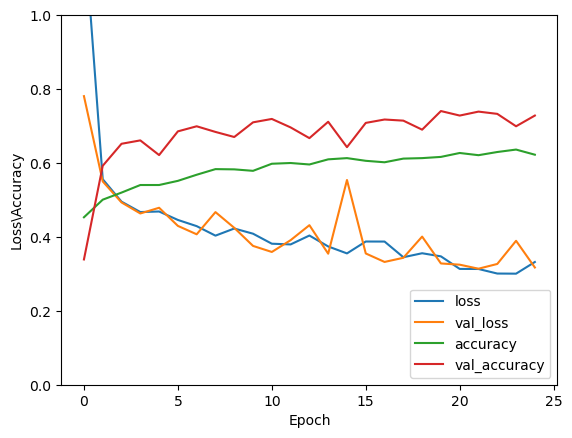

In [8]:
# Plot the loss and accuracy of the model
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss\Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [9]:
# Evaluate the model on the testing dataset
# This is the final accuracy of the model
test_loss, test_acc = model.evaluate(testing_dataset, verbose=2)
print("Testing Data Accuracy: ", end="")
print(test_acc * 100)
print("Testing Data Loss: ", end="")
print(test_loss)

21/21 - 2s - loss: 0.3279 - accuracy: 0.7191 - 2s/epoch - 106ms/step
Testing Data Accuracy: 71.90839648246765
Testing Data Loss: 0.3278580904006958


### Get the Predictions and Visualize the Results

In this stage, we get the predictions of the model on the testing set and visualize the results. The model also predicts on a new mono and poly set of images and the results are visualized.
The results have the metrics for the model, and they include the F1 score, a Confusion Matrix and a Classification Report.

In [10]:
# Creating the mono and poly datasets
# The mono and poly datasets are created by seperating the images into mono and poly images
# The images are then seperated into validation, and testing sets via stratified sampling
# The mono and poly datasets are then made into testing and validation datasets for each type


# Create mono and poly empty arrays
mono_images = []
mono_proba = []

poly_images = []
poly_proba = []


# Seperate the images into mono and poly images
for i in range(len(types)):
    if types[i] == 'mono':
        mono_images.append(images[i])
        mono_proba.append(proba[i])
    elif types[i] == 'poly':
        poly_images.append(images[i])
        poly_proba.append(proba[i])


# Convert the mono and poly arrays to numpy arrays
mono_images = np.array(mono_images)
mono_proba = np.array(mono_proba)

poly_images = np.array(poly_images)
poly_proba = np.array(poly_proba)


# Seperate the mono and poly images into testing and validation sets
mono_testing_data = []
mono_testing_labels = []

mono_validation_data = []
mono_validation_labels = []

poly_testing_data = []
poly_testing_labels = []

poly_validation_data = []
poly_validation_labels = []


# Mono and poly images are seperated into testing and validation sets

# Mono
# Use stratified sampling to ensure that the testing and validation sets have the same distribution of classes
for label in unique_proba:
    indices = np.where(mono_proba == label)[0]
    
    sample_size = int((len(mono_images) * 0.5) * len(indices) / len(mono_images))
    
    sample_testing_indices = np.random.choice(indices, size=sample_size, replace = False)
    sample_validation_indices = np.random.choice(indices, size=sample_size, replace = False)
    
    mono_testing_data.append(mono_images[sample_testing_indices])
    mono_testing_labels.append(mono_proba[sample_testing_indices])
    
    mono_validation_data.append(mono_images[sample_validation_indices])
    mono_validation_labels.append(mono_proba[sample_validation_indices])

# Poly
# Use stratified sampling to ensure that the testing and validation sets have the same distribution of classes
for label in unique_proba:
    indices = np.where(poly_proba == label)[0]
    
    sample_size = int((len(poly_images) * 0.5) * len(indices) / len(poly_images))
    
    sample_testing_indices = np.random.choice(indices, size=sample_size, replace = False)
    sample_validation_indices = np.random.choice(indices, size=sample_size, replace = False)
    
    poly_testing_data.append(poly_images[sample_testing_indices])
    poly_testing_labels.append(poly_proba[sample_testing_indices])

    poly_validation_data.append(poly_images[sample_validation_indices])
    poly_validation_labels.append(poly_proba[sample_validation_indices])

    
# Creating new numpy arrays with the correct shape for the testing and validation sets

# Mono
mono_size = int((len(mono_images) * 0.5))
mt_data = np.zeros(shape=(mono_size, 300, 300, 3), dtype=np.uint8)
mt_labels = np.zeros(shape=(mono_size,))

mv_data = np.zeros(shape=(mono_size, 300, 300, 3), dtype=np.uint8)
mv_labels = np.zeros(shape=(mono_size,))

# Poly
poly_size = int((len(poly_images) * 0.5))
pt_data = np.zeros(shape=(poly_size, 300, 300, 3), dtype=np.uint8)
pt_labels = np.zeros(shape=(poly_size,))

pv_data = np.zeros(shape=(poly_size, 300, 300, 3), dtype=np.uint8)
pv_labels = np.zeros(shape=(poly_size,))


# Fill the numpy arrays with the images and labels from the mono images
index = 0
for i in range(len(mono_testing_data)):
    for j in range(len(mono_testing_data[i])):
        temp = mono_testing_data[i][j]
        mt_data[index] = temp
        temp = mono_testing_labels[i][j]
        mt_labels[index] = temp
        
        temp = mono_validation_data[i][j]
        mv_data[index] = temp
        temp = mono_validation_labels[i][j]
        mv_labels[index] = temp
        index += 1


# Fill the numpy arrays with the images and labels from the poly images
index = 0
for i in range(len(poly_testing_data)):
    for j in range(len(poly_testing_data[i])):
        temp = poly_testing_data[i][j]
        pt_data[index] = temp
        temp = poly_testing_labels[i][j]
        pt_labels[index] = temp
        
        temp = poly_validation_data[i][j]
        pv_data[index] = temp
        temp = poly_validation_labels[i][j]
        pv_labels[index] = temp
        index += 1


# Normalize the images to be between 0 and 1
mt_data, mv_data, pt_data, pv_data = mt_data / 255.0, mv_data / 255.0, pt_data / 255.0, pv_data / 255.0


# Create the datasets
mt_dataset = tf.data.Dataset.from_tensor_slices((mt_data, mt_labels))
mt_dataset = mt_dataset.shuffle(len(mono_testing_data))
mt_dataset = mt_dataset.batch(32)

mv_dataset = tf.data.Dataset.from_tensor_slices((mv_data, mv_labels))
mv_dataset = mv_dataset.shuffle(len(mono_validation_data))
mv_dataset = mv_dataset.batch(32)

pt_dataset = tf.data.Dataset.from_tensor_slices((pt_data, pt_labels))
pt_dataset = pt_dataset.shuffle(len(poly_testing_data))
pt_dataset = pt_dataset.batch(32)

pv_dataset = tf.data.Dataset.from_tensor_slices((pv_data, pv_labels))
pv_dataset = pv_dataset.shuffle(len(poly_validation_data))
pv_dataset = pv_dataset.batch(32)


In [11]:
# This helper function creates new arrays which satisfy the requirements for the calculation of the f1 score
# and other metrics
def get_pred_labels(predictions, label):
    
    # Go through the predictions and set the prediction with the highest probability to 1
    # and the rest to 0
    for i in range(len(predictions)):
        curr_max = 0
        max_index = 0
        for j in range(len(predictions[i])):
            if predictions[i][j] > curr_max:
                curr_max = predictions[i][j]
                max_index = j
        
        predictions[i][:] = 0
        predictions[i][max_index] = 1

    # Create a new array for the predictions and set the predictions to the correct values
    new_pred = np.zeros(shape=(len(predictions),))
    for i in range(len(predictions)):
        if predictions[i][0] == 1:
            new_pred[i] = 1
        elif predictions[i][1] == 1:
            new_pred[i] = 2
        elif predictions[i][2] == 1:
            new_pred[i] = 3
        elif predictions[i][3] == 1:
            new_pred[i] = 4
        
    # Create a new array for the labels and set the labels to the correct values
    new_labels = np.zeros(shape=(len(label),))
    for i in range(len(label)):
        if label[i] == 0.:
            new_labels[i] = 1
        if label[i] == 0.3333333333333333:
            new_labels[i] = 2
        if label[i] == 0.6666666666666666:
            new_labels[i] = 3
        if label[i] == 1.:
            new_labels[i] = 4

    # Return the new predictions and labels
    return new_pred, new_labels

In [14]:
# Use the model to predict the labels of the normal testing set
predictions = model.predict(testing_dataset)

# Get the new predictions and labels
new_pred, new_labels = get_pred_labels(predictions, testing_labels)

# Print the confusion matrix and classification report
print("Testing Data Accuracy: ")
print(f'F1 Score: {metrics.f1_score(new_labels, new_pred, average="weighted")}')
print(f'Confusion Matrix: \n{metrics.confusion_matrix(new_labels, new_pred)}')
print(f'Classification Report: \n{metrics.classification_report(new_labels, new_pred)}')


21/21 [==============================] - 2s 93ms/step
Testing Data Accuracy: 
F1 Score: 0.4097050857910346
Confusion Matrix: 
[[314  64   0   0]
 [ 59  14   0   0]
 [ 23   3   0   0]
 [149  29   0   0]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.58      0.83      0.68       378
         2.0       0.13      0.19      0.15        73
         3.0       0.00      0.00      0.00        26
         4.0       0.00      0.00      0.00       178

    accuracy                           0.50       655
   macro avg       0.18      0.26      0.21       655
weighted avg       0.35      0.50      0.41       655



c:\Users\pkay\anaconda3\envs\assignment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pkay\anaconda3\envs\assignment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pkay\anaconda3\envs\assignment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# Predict and Evaluate the model on the mono dataset

# Use the model to predict the labels of the mono testing set and get the new predictions and labels
m_predictions = model.predict(mt_dataset)
m_new_pred, m_new_labels = get_pred_labels(m_predictions, mt_labels)

# Print the F1 score, confusion matrix and classification report
print("Mono Testing Data Accuracy: ")
print(f'F1 Score: {metrics.f1_score(m_new_labels, m_new_pred, average="weighted")}')
print(f'Confusion Matrix: \n{metrics.confusion_matrix(m_new_labels, m_new_pred)}')
print(f'Classification Report: \n{metrics.classification_report(m_new_labels, m_new_pred)}')

# Use the model to predict the labels of the mono validation set and get the new predictions and labels
mv_predictions = model.predict(mv_dataset)
mv_new_pred, mv_new_labels = get_pred_labels(mv_predictions, mv_labels)

# Print the F1 score, confusion matrix and classification report
print("Mono Validation Data Accuracy: ")
print(f'F1 Score: {metrics.f1_score(mv_new_labels, mv_new_pred, average="weighted")}')
print(f'Confusion Matrix: \n{metrics.confusion_matrix(mv_new_labels, mv_new_pred)}')
print(f'Classification Report: \n{metrics.classification_report(mv_new_labels, mv_new_pred)}')


# Predict and Evaluate the model on the poly dataset

# Use the model to predict the labels of the poly testing set and get the new predictions and labels
p_predictions = model.predict(pt_dataset)
p_new_pred, p_new_labels = get_pred_labels(p_predictions, pt_labels)

# Print the F1 score, confusion matrix and classification report
print("Poly Testing Data Accuracy: ")
print(f'F1 Score: {metrics.f1_score(p_new_labels, p_new_pred, average="weighted")}')
print(f'Confusion Matrix: \n{metrics.confusion_matrix(p_new_labels, p_new_pred)}')
print(f'Classification Report: \n{metrics.classification_report(p_new_labels, p_new_pred)}')

# Use the model to predict the labels of the poly validation set and get the new predictions and labels
pv_predictions = model.predict(pv_dataset)
pv_new_pred, pv_new_labels = get_pred_labels(pv_predictions, pv_labels)

# Print the F1 score, confusion matrix and classification report
print("Poly Validation Data Accuracy: ")
print(f'F1 Score: {metrics.f1_score(pv_new_labels, pv_new_pred, average="weighted")}')
print(f'Confusion Matrix: \n{metrics.confusion_matrix(pv_new_labels, pv_new_pred)}')
print(f'Classification Report: \n{metrics.classification_report(pv_new_labels, pv_new_pred)}')

17/17 [==============================] - 1s 84ms/step
Mono Testing Data Accuracy: 
F1 Score: 0.4297259392990803
Confusion Matrix: 
[[282  13   0   0]
 [ 58   0   0   0]
 [ 26   2   0   0]
 [ 60  96   0   0]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.66      0.96      0.78       295
         2.0       0.00      0.00      0.00        58
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00       156

    accuracy                           0.53       537
   macro avg       0.17      0.24      0.20       537
weighted avg       0.36      0.53      0.43       537

 2/17 [==>...........................] - ETA: 1s

c:\Users\pkay\anaconda3\envs\assignment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pkay\anaconda3\envs\assignment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pkay\anaconda3\envs\assignment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


17/17 [==============================] - 1s 86ms/step
Mono Validation Data Accuracy: 
F1 Score: 0.43670508663936203
Confusion Matrix: 
[[283  12   0   0]
 [ 57   1   0   0]
 [ 26   2   0   0]
 [ 53 103   0   0]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.68      0.96      0.79       295
         2.0       0.01      0.02      0.01        58
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00       156

    accuracy                           0.53       537
   macro avg       0.17      0.24      0.20       537
weighted avg       0.37      0.53      0.44       537

 2/25 [=>............................] - ETA: 2s

c:\Users\pkay\anaconda3\envs\assignment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pkay\anaconda3\envs\assignment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pkay\anaconda3\envs\assignment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


25/25 [==============================] - 2s 83ms/step
Poly Testing Data Accuracy: 
F1 Score: 0.4777584180674699
Confusion Matrix: 
[[458   2   0   0]
 [ 88   1   0   0]
 [ 24   1   0   0]
 [111  90   0   0]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.67      1.00      0.80       460
         2.0       0.01      0.01      0.01        89
         3.0       0.00      0.00      0.00        25
         4.0       0.00      0.00      0.00       201

    accuracy                           0.59       775
   macro avg       0.17      0.25      0.20       775
weighted avg       0.40      0.59      0.48       775

 2/25 [=>............................] - ETA: 1s

c:\Users\pkay\anaconda3\envs\assignment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pkay\anaconda3\envs\assignment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pkay\anaconda3\envs\assignment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


25/25 [==============================] - 2s 80ms/step
Poly Validation Data Accuracy: 
F1 Score: 0.47483870967741926
Confusion Matrix: 
[[456   4   0   0]
 [ 89   0   0   0]
 [ 24   1   0   0]
 [111  90   0   0]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.67      0.99      0.80       460
         2.0       0.00      0.00      0.00        89
         3.0       0.00      0.00      0.00        25
         4.0       0.00      0.00      0.00       201

    accuracy                           0.59       775
   macro avg       0.17      0.25      0.20       775
weighted avg       0.40      0.59      0.47       775



c:\Users\pkay\anaconda3\envs\assignment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pkay\anaconda3\envs\assignment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pkay\anaconda3\envs\assignment\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
